In [19]:
from pyradiosky import SkyModel, utils
import numpy as np
from astropy.table import Table, setdiff
from astropy.utils.diff import report_diff_values
from astropy.io import fits
from operator import itemgetter
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import psutil
import erfa
import csv
sm = SkyModel()

gleam_catalog = sm.from_gleam_catalog("/Users/Kiana1/uwradcos/gleam.vot", spectral_type = "subband", with_error = True)
gleam_spectral_index = sm.from_gleam_catalog("/Users/Kiana1/uwradcos/gleam.vot", spectral_type = "spectral_index", with_error = True)

In [4]:
def log_linear_fit(freqs, fit_data, stokes_error, dec, detect_outlier = False):
    ## Compute combined error, fit logged data to linear polynomial, calculate chi2 residual
    # Calculate coord-based portion of error
    if (dec >= 18.5) or (dec <= -72):
        loc_error = fit_data * .03
    else:
        loc_error = fit_data * .02
    
    # Compute total error and weight for the polyfit
    total_error = np.sqrt(loc_error**2 + stokes_error**2)
    weight = np.log10(1 / total_error)
    
    # Take logs of data and freqs for polyfit
    fit_data_log = np.log10(fit_data)
    freqs_log = np.log10(freqs)
    all_freqs_log = np.log10(gleam_catalog.freq_array.value)
    
    # Subset to freqs with no nans in vals or errors and do polyfit on only those freqs
    idx = np.isfinite(freqs_log) & np.isfinite(fit_data_log) & np.isfinite(weight)
    
    # coeffs is a pair of numbers (b, m) corresponding to the equation y=b+mx
    coeffs = poly.polyfit(freqs_log[idx], fit_data_log[idx], w = weight[idx], deg=1)
    
    # Use coeffs to generate modeled vals at only freqs that were used to make coeffs
    fit_log = poly.polyval(freqs_log[idx], coeffs)
    fitted_data = 10**fit_log
    
    # use coefficients to generate modeled vals at all 20 freqs
    full_fit_log = poly.polyval(all_freqs_log, coeffs)
    all_freqs_fitted_data = 10**full_fit_log
    
    # generate modeled val at 50 MHz
    low_fit_log = poly.polyval(np.log10(50000000), coeffs)
    low_fit = 10**low_fit_log
    
    #compute chi2 value
    variance = total_error[idx]**2
    residual = fit_data[idx] - fitted_data
    chi2 = sum((residual**2) / variance)
    chi2_residual = chi2 / (len(freqs[idx]) - 2)
    
    fitted_freqs = freqs[idx]
    fit_data_selected = fit_data[idx]
    
    original_parameters = np.array([[float("NaN")]])
    # Outlier detection reruns fit without greatest outlier
    if detect_outlier == True:
        idx_outlier = np.argmax(abs(residual))
        
        # create datasets with outlier removed
        log_data_ol = np.delete(fit_data_log[idx], idx_outlier)
        log_freq_ol = np.delete(freqs_log[idx], idx_outlier)
        weight_ol = np.delete(weight[idx], idx_outlier)
        
        #fit without the outlier
        coeffs_ol = poly.polyfit(log_freq_ol, log_data_ol, w = weight_ol, deg=1)
        
        fit_log_ol = poly.polyval(log_freq_ol, coeffs_ol)
        fitted_data_ol = 10**fit_log_ol
        full_fit_log_ol = poly.polyval(all_freqs_log, coeffs_ol)
        all_freqs_fitted_data_ol = 10**full_fit_log_ol
        
        # compute chi2 using this new fit
        variance_ol = np.delete(total_error[idx], idx_outlier)**2
        residual_ol = np.delete(fit_data[idx], idx_outlier) - np.delete(fitted_data, idx_outlier)
        
        chi2_ol = sum((residual_ol**2) / variance_ol)
        chi2_residual_ol = chi2_ol / (len(np.delete(freqs[idx], idx_outlier)) - 2)
        

        # see if fit has improved
        if chi2_residual_ol < chi2_residual / 2.6:
            
            original_parameters = np.array([coeffs, chi2_residual, fitted_data, all_freqs_fitted_data, fitted_freqs, fit_data_selected], dtype=object)
            
            #reassign values with outlier removed version of fit
            chi2_residual = chi2_residual_ol
            coeffs = coeffs_ol
            fitted_data = fitted_data_ol
            all_freqs_fitted_data = all_freqs_fitted_data_ol
            fitted_freqs = np.delete(freqs[idx], idx_outlier)
            fit_data_selected = np.delete(fit_data[idx], idx_outlier)
    
    return(coeffs, chi2_residual, fitted_data, all_freqs_fitted_data, fitted_freqs, fit_data_selected, original_parameters, low_fit)

Mean of empty slice
Degrees of freedom <= 0 for slice.
divide by zero encountered in log10


In [10]:
def low_freq_thing():
    #Initialize arrays
    source_dict = {}
    bad_chi2 = []
    averages = []
    fit_averages = []
    problem_objs = []
    

    # Separate all rows that contain nans
    for source in np.arange(gleam_catalog.Ncomponents):
        
        fit_data = gleam_catalog.stokes.value[0,:,source]
        dec = gleam_catalog.dec.value[source]
        freqs = gleam_catalog.freq_array.value
        stokes_error = gleam_catalog.stokes_error.value[0,:,source]

        # Calculate variance between fluxes for final dict
        #with warnings.catch_warnings():
            
            # Ignore warnings caused by some sources having 1 or 0 data points
        #    warnings.filterwarnings(action = "ignore", message="divide by zero encountered in log10")
        #    warnings.filterwarnings(action = "ignore", message="Degrees of freedom <= 0 for slice.")
        #    warnings.filterwarnings(action = "ignore", message="Mean of empty slice")
        mean_adj_data = (fit_data - np.nanmean(fit_data)) / np.nanmean(fit_data)
            
        diff = np.diff(mean_adj_data)
        source_variance = np.nanvar(diff)

        #Initialize arrays for half and quarter fits
        out2 = np.array([[float("NaN")], [float("NaN")], [float("NaN")], [float("NaN")]])
        out3 = np.array([[float("NaN")], [float("NaN")], [float("NaN")], [float("NaN")]])

        # Find sources that have missing values in only one of error and vals
        source_probs = []
        for i in range(len(fit_data)):
            if np.isnan(fit_data[i]):
                if ~np.isnan(stokes_error[i]) and not source_probs:
                    source_probs.append([fit_data, stokes_error])
            else:
                if np.isnan(stokes_error[i]) and not source_probs:
                    source_probs.append([fit_data, stokes_error])

        # Only include in problems list if there WAS a problem, exclude source from rest of fitting
        if source_probs:
            problem_objs.append([source, gleam_catalog.ra.value[source], gleam_catalog.dec.value[source], source_probs])
            continue

        # Eliminate negative fluxes by turning into nans before fitting
        fit_data[fit_data < 0] = np.nan
        indices = np.argwhere(~np.isnan(fit_data)).flatten()

        # Skip sources with no values
        if np.all(np.isnan(fit_data)):
            continue

        # Perform full fit using all freqs available for source
        out1 = log_linear_fit(freqs, fit_data, stokes_error, dec, detect_outlier = True)
        
        #Transfer output to 'out', which is the final output variable, to save results from this fit in out1
        out = out1

        # if chi2_residual is >=1.93 and brighter than 1Jy at 150MHz, fit again with fewer freqs
        if out[1] >= 1.93:
            if fit_data[9]>=1:

                # Fit with bottom half of freqs
                if len(fit_data[indices]) >= 8:
                    half_freqs = freqs[indices[:int(len(indices) / 2)]]
                    fit_data_half = fit_data[indices[:int(len(indices) / 2)]]
                    error_half = stokes_error[indices[:int(len(indices) / 2)]]

                    # Fit with bottom half of freqs
                    out2 = log_linear_fit(half_freqs, fit_data_half, error_half, dec)
                    out = out2

                    # if 2nd fit has poor chi2, fit with bottom 1/4 freqs
                    if out[1] >= 1.93:
                        # If original freqs >=16, fit on bottom 1/4
                        if len(half_freqs) >= 8:
                            qt_freqs = half_freqs[:int(len(half_freqs) / 2)]
                            fit_data_qt = fit_data_half[:int(len(half_freqs) / 2)]
                            error_qt = error_half[:int(len(half_freqs) / 2)]

                            out3 = log_linear_fit(qt_freqs, fit_data_qt, error_qt, dec)
                            out = out3

                        # If there are <16 total non-nan frequencies, fit on bottom 4
                        else:
                            bottom_freqs = freqs[indices[:4]]
                            fit_data_bottom = fit_data[indices[:4]]
                            error_bottom = stokes_error[indices[:4]]

                            out3 = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec)  
                            out = out3

                else:
                    # If bottom half of freqs is small, run fit on bottom 4 freqs, and do not attempt 3rd fit
                    bottom_freqs = freqs[indices[:4]]
                    fit_data_bottom = fit_data[indices[:4]]
                    error_bottom = stokes_error[indices[:4]]

                    # Fit with bottom half of freqs
                    out2 = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec)
                    out = out2


        # if chi2_residual is still large after all iterations, take lowest one
        if out[1] >= 1.93:
            bad_chi2.append([source, out1[3], out2[3], out3[3], out1[1], out2[1], out3[1]])

            # select best of 3 fit options by chi2 val and use as final fit
            prev_rounds = {"out1": out1[1], "out2": out2[1], "out3": out3[1]}
            best_fit = min(prev_rounds, key=prev_rounds.get)
            out = eval(best_fit)


        fit_averages.append(np.average(out[3]))

        # Create dict with final vals
        source_vars = {
            "ra": gleam_catalog.ra.value[source],
            "dec": dec,
            "coefficients": out[0],
            "chi2_residual": out[1],
            "prev_fit_data": [out1[3], out2[3], out3[3], out1[1], out2[1], out3[1], out1[2], out2[2], out3[2], 
                              out1[0]],
            "fitted_data": out[2],
            "all_freqs_fitted_data": out[3],
            "freqs": freqs,
            "freqs_used_for_fit": out[4],
            "data_used_for_fit": out[5],
            "pre_outlier_removal_output": out[6],
            "variance": source_variance,
            "50_mhz_extrapolation": [out[7], out1[7]]
        }
        
        # source_dict is a dict of dicts
        source_dict[source] = source_vars
    return(source_dict)

In [22]:
def low_freq_multifit():
    """
    This function performs a multi-layered fit of the GLEAM catalog sources with a preference for low frequencies.
    A fit is always based on at least 4 data points.
    For a given source;
        1. Replace any negative fluxes with NaN's
        2. Run 'log_linear_fit' function on source data, checking for significant outliers
        3. If the source is >1Jy at 150 MHz, and if the reduced chi2 of the fit is >= 1.93, run 'log_linear_fit'
        again, on only the bottom half of available frequencies for the source. Sources dimmer than 1Jy do not
        show much fit improvement by reducing the number of frequencies, because their scatter is high.
        4. If the reduced chi2 of the fit of the bottom half of frequencies is still >= 1.93, AND there are at
        least 8 frequencies in the bottom half of frequencies, run 'log_linear_fit' a third time on only the
        bottom quarter of frequencies for the source.
        5. If the reduced chi2 is still >= 1.93, the fit with the lowest chi2 is selected as the best fit.
        6. Parameters and data for the best/final fit are put into a dict, which also includes a keyword whose
        value is all the parameters of any previous fits.
    
    Parameters
    ----------
    catalog_loc : str
        The full file location of the gleam catalog.
        
    Returns
    -------
    source_dict : dict
        A dictionary containing dicts of the data and parameters for the best fit for each source.
        For a given source, the dict contains:
            ra : ndarray
                The Right Ascension of the source
            dec : ndarray
                The declination of the source.
            coefficients : 
                The coefficients of the best fit, [b, m] corresponding to y=b+mx, the linear fit of logged
                source data.
            chi2_residual : float
                The reduced chi2 value of the best fit of the source.
            prev_fit_data : 
                Data from previous fits that were not the best fit. If a source did not have a given fit,
                the value is NaN. For example if there were only a full and half fit, values corresponding
                to the quarter fit will be NaN.
                In order:
                - Data for all frequencies 'all_freqs_fitted_data' from full fit
                - Data for all frequencies from half fit
                - Data for all frequencies from quarter fit
                - Chi2 residual 'chi2_residual' from full fit
                - Chi2 residual from half fit
                - Chi2 residual from quarter fit
                - Data from only provided freqs 'fitted_data' from full fit
                - Data from only provided freqs from half fit
                - Data from only provided freqs from quarter fit
                - Coefficients from the initial full fit, 'coeffs'
            fitted_data : 
                Modeled fluxes at only the frequencies provided in 'freqs'
            freqs :
                All frequencies in GLEAM
            freqs_used_for_fit : 
                Only frequencies used by 'log_linear_fit', corresponds to the 'fitted_freqs' output from
                'log_linear_fit'
            data_used_for_fit : 
                Fluxes corresponding to the 'freqs_used_for_fit' frequencies. Corresponds to the 'fit_data_selected'
                output from 'log_linear_fit'
            pre_outlier_removal_output :
                Contains data from the 'original_parameters' output from 'log_linear_fit'. These are all the data, 
                coefficients, etc from a fit where outliers were checked for and if necessary removed.
            variance : 
                The variance is a measure of the scatter of the original flux data. Flux data is normalized,
                and then the difference between adjacent points is calculated. The variance describes
                overall how closely aligned adjacent datapoints are. A low variance indicates a low scatter,
                and datapoints that follow an overall trend. High variance indicates that there is a lot of 
                intrinsic data scatter. This can be useful in looking at overall goodness of fit, since we'd
                expect sources with a lot of intrinsic scatter and a high variance to have mediocre fits due to
                data quality issues. Conversely, a poor fit on a source with low variance would be something
                to be concerned about.
            50_mhz_extrapolation :
                 - Projected flux at 50 MHz for the best of all fits performed.
                 - Projected flux at 50 MHz for the initial fit on all available frequencies.
    
    """

    #Import gleam source catalog
    #gleam_catalog = sm.from_gleam_catalog(catalog_loc, spectral_type = "subband", with_error = True)
    
    #Initialize arrays
    source_dict = {}
    bad_chi2 = []
    averages = []
    fit_averages = []
    problem_objs = []
    

    # Separate all rows that contain nans
    for source in np.arange(gleam_catalog.Ncomponents):
        
        fit_data = gleam_catalog.stokes.value[0,:,source]
        dec = gleam_catalog.dec.value[source]
        freqs = gleam_catalog.freq_array.value
        stokes_error = gleam_catalog.stokes_error.value[0,:,source]

        # Calculate variance between fluxes for final dict
        #with warnings.catch_warnings():
            
            # Ignore warnings caused by some sources having 1 or 0 data points
        #    warnings.filterwarnings(action = "ignore", message="divide by zero encountered in log10")
        #    warnings.filterwarnings(action = "ignore", message="Degrees of freedom <= 0 for slice.")
        #    warnings.filterwarnings(action = "ignore", message="Mean of empty slice")
        mean_adj_data = (fit_data - np.nanmean(fit_data)) / np.nanmean(fit_data)
            
        diff = np.diff(mean_adj_data)
        source_variance = np.nanvar(diff)

        #Initialize arrays for half and quarter fits
        out2 = np.array([[float("NaN")], [float("NaN")], [float("NaN")], [float("NaN")]])
        out3 = np.array([[float("NaN")], [float("NaN")], [float("NaN")], [float("NaN")]])

        # Find sources that have missing values in only one of error and vals
        source_probs = []
        for i in range(len(fit_data)):
            if np.isnan(fit_data[i]):
                if ~np.isnan(stokes_error[i]) and not source_probs:
                    source_probs.append([fit_data, stokes_error])
            else:
                if np.isnan(stokes_error[i]) and not source_probs:
                    source_probs.append([fit_data, stokes_error])

        # Only include in problems list if there WAS a problem, exclude source from rest of fitting
        if source_probs:
            problem_objs.append([source, gleam_catalog.ra.value[source], gleam_catalog.dec.value[source], source_probs])
            continue

        # Eliminate negative fluxes by turning into nans before fitting
        fit_data[fit_data < 0] = np.nan
        indices = np.argwhere(~np.isnan(fit_data)).flatten()

        # Skip sources with no values
        if np.all(np.isnan(fit_data)):
            continue

        # Perform full fit using all freqs available for source
        out1 = log_linear_fit(freqs, fit_data, stokes_error, dec, detect_outlier = True)
        
        #Transfer output to 'out', which is the final output variable, to save results from this fit in out1
        out = out1

        # if chi2_residual is >=1.93 and brighter than 1Jy at 150MHz, fit again with fewer freqs
        if out[1] >= 1.93:
            if fit_data[9]>=1:

                # Fit with bottom half of freqs
                if len(fit_data[indices]) >= 8:
                    half_freqs = freqs[indices[:int(len(indices) / 2)]]
                    fit_data_half = fit_data[indices[:int(len(indices) / 2)]]
                    error_half = stokes_error[indices[:int(len(indices) / 2)]]

                    # Fit with bottom half of freqs
                    out2 = log_linear_fit(half_freqs, fit_data_half, error_half, dec)
                    out = out2

                    # if 2nd fit has poor chi2, fit with bottom 1/4 freqs
                    if out[1] >= 1.93:
                        # If original freqs >=16, fit on bottom 1/4
                        if len(half_freqs) >= 8:
                            qt_freqs = half_freqs[:int(len(half_freqs) / 2)]
                            fit_data_qt = fit_data_half[:int(len(half_freqs) / 2)]
                            error_qt = error_half[:int(len(half_freqs) / 2)]

                            out3 = log_linear_fit(qt_freqs, fit_data_qt, error_qt, dec)
                            out = out3

                        # If there are <16 total non-nan frequencies, fit on bottom 4
                        else:
                            bottom_freqs = freqs[indices[:4]]
                            fit_data_bottom = fit_data[indices[:4]]
                            error_bottom = stokes_error[indices[:4]]

                            out3 = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec)  
                            out = out3

                else:
                    # If bottom half of freqs is small, run fit on bottom 4 freqs, and do not attempt 3rd fit
                    bottom_freqs = freqs[indices[:4]]
                    fit_data_bottom = fit_data[indices[:4]]
                    error_bottom = stokes_error[indices[:4]]

                    # Fit with bottom half of freqs
                    out2 = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec)
                    out = out2


        # if chi2_residual is still large after all iterations, take lowest one
        if out[1] >= 1.93:
            bad_chi2.append([source, out1[3], out2[3], out3[3], out1[1], out2[1], out3[1]])

            # select best of 3 fit options by chi2 val and use as final fit
            prev_rounds = {"out1": out1[1], "out2": out2[1], "out3": out3[1]}
            best_fit = min(prev_rounds, key=prev_rounds.get)
            out = eval(best_fit)


        fit_averages.append(np.average(out[3]))

        # Create dict with final vals
        source_vars = {
            "ra": gleam_catalog.ra.value[source],
            "dec": dec,
            "coefficients": out[0],
            "chi2_residual": out[1],
            "prev_fit_data": [out1[3], out2[3], out3[3], out1[1], out2[1], out3[1], out1[2], out2[2], out3[2], 
                              out1[0]],
            "fitted_data": out[2],
            "all_freqs_fitted_data": out[3],
            "freqs": freqs,
            "freqs_used_for_fit": out[4],
            "data_used_for_fit": out[5],
            "pre_outlier_removal_output": out[6],
            "variance": source_variance,
            "50_mhz_extrapolation": [out[7], out1[7]]
        }
        
        # source_dict is a dict of dicts
        source_dict[source] = source_vars
    return(source_dict)

In [25]:
source_dict2 = low_freq_thing()

Mean of empty slice
Degrees of freedom <= 0 for slice.
divide by zero encountered in log10


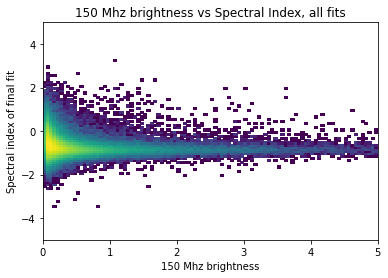

In [26]:
from matplotlib.colors import LogNorm

#midband comparison
midband = []
diff = []

for i in source_dict2:
    if i in source_dict2:
        #if 105 <= source_dict[i]["ra"] <= 255:
        #    if 26 <= source_dict[i]['dec']<=34:
        #if np.isnan(source_dict[i]['prev_chi2_residuals'][1][0]):
        #        continue
        #else:
                midband.append(source_dict2[i]['prev_fit_data'][0][9])
                first = source_dict2[i]['prev_fit_data'][9][1]
                last = source_dict2[i]['coefficients'][1]
                diff.append(last)


plt.hist2d(midband, diff, bins = 100, norm=LogNorm(), range = [[0,5],[-5,5]])
plt.xlabel("150 Mhz brightness")
plt.ylabel("Spectral index of final fit")
plt.title("150 Mhz brightness vs Spectral Index, all fits")
plt.savefig("/Users/Kiana1/uwradcos/plots/spind_hist2d.png")

In [1]:
import sys
sys.path.append("/Users/Kiana1/uwradcos/scripts/")
import gleam_low_freq_fits

In [2]:
test = gleam_low_freq_fits.low_freq_multifit("/Users/Kiana1/uwradcos/gleam.vot")

Mean of empty slice
Degrees of freedom <= 0 for slice.
divide by zero encountered in log10


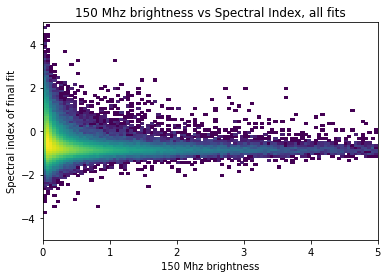

In [3]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

#midband comparison
midband = []
diff = []

for i in test:
    if i in test:
        #if 105 <= source_dict[i]["ra"] <= 255:
        #    if 26 <= source_dict[i]['dec']<=34:
        #if np.isnan(source_dict[i]['prev_chi2_residuals'][1][0]):
        #        continue
        #else:
                midband.append(test[i]['prev_fit_data'][0][9])
                first = test[i]['prev_fit_data'][9][1]
                last = test[i]['coefficients'][1]
                diff.append(last)


plt.hist2d(midband, diff, bins = 100, norm=LogNorm(), range = [[0,5],[-5,5]])
plt.xlabel("150 Mhz brightness")
plt.ylabel("Spectral index of final fit")
plt.title("150 Mhz brightness vs Spectral Index, all fits")
plt.savefig("/Users/Kiana1/uwradcos/plots/spind_hist2d.png")